In [21]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns


def find_outliers(df, threshold=2):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Return the indices of the outliers
    outlier_indices = df[outlier_rows_mask].index
    return outlier_indices

In [22]:
df = pd.read_csv("../outputs/data_clean_fpar_lai_ci2.csv")
df.set_index(pd.to_datetime(df.iloc[:, 0], format="%Y-%m-%d"), inplace=True)
df = df.drop(df.columns[0], axis=1)

In [23]:
df

,gpp,par,red,nir,fpar,lai,ndvi,nirv,nirvp,fesc,fesc_p,fesc_n,lue,name,type,Lat,Lon,ci
Unnamed: 0,,,,,,,,,,,,,,,,,,
2002-07-04,7.220345,628.195833,0.0348,0.2135,0.640000,1.700,0.719694,0.153655,96.525212,0.240085,150.820644,0.000382,0.017959,IT-SRo,ENF,43.7279,10.2844,NaN
2002-07-05,7.308355,615.737500,0.0378,0.2213,0.675000,2.050,0.708221,0.156729,96.504080,0.232191,142.969007,0.000377,0.017584,IT-SRo,ENF,43.7279,10.2844,NaN
2002-07-06,5.897100,426.125000,0.0380,0.2215,0.710000,2.400,0.707129,0.156629,66.743573,0.220604,94.005032,0.000518,0.019491,IT-SRo,ENF,43.7279,10.2844,NaN
2002-07-07,7.338210,587.804167,0.0381,0.2216,0.745000,2.750,0.706585,0.156579,92.037865,0.210173,123.540758,0.000358,0.016757,IT-SRo,ENF,43.7279,10.2844,NaN
2002-07-08,6.478290,623.954167,0.0382,0.2218,0.780000,3.100,0.706154,0.156625,97.726773,0.200801,125.290735,0.000322,0.013311,IT-SRo,ENF,43.7279,10.2844,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-07,4.799735,204.387687,0.0264,0.2477,0.938333,4.525,0.807370,0.199985,40.874562,0.213128,43.560812,0.001043,0.025027,CA-TP4,ENF,42.7102,-80.3574,NaN
2014-10-11,5.950615,409.667479,0.0253,0.2327,0.925000,4.125,0.803876,0.187062,76.633193,0.202229,82.846695,0.000494,0.015703,CA-TP4,ENF,42.7102,-80.3574,NaN
2014-10-12,5.224940,409.656813,0.0251,0.2325,0.920000,4.000,0.805124,0.187191,76.684225,0.203469,83.352418,0.000497,0.013864,CA-TP4,ENF,42.7102,-80.3574,NaN


In [24]:
ameriflux_coords = pd.read_csv("../data/Ameriflux_coords.csv")
fluxnet_coords = pd.read_csv("../data/Fluxnet_coords.csv")
merged_coords = pd.concat([ameriflux_coords, fluxnet_coords], ignore_index=True)
merged_coords.drop_duplicates(subset=merged_coords.columns[0], inplace=True)
merged_coords.reset_index(drop=True, inplace=True)
merged_coords.rename({"Name": "name"}, axis=1, inplace=True)

In [25]:
# df = df[~df.type.isin(["SNO", "CVM"])]
# df['type'] = df['type'].replace(['OSH', 'CSH'], 'SH')
names = df["name"].unique()
types = df["type"].unique()

In [26]:
site_annual_max_lue = []
site_annual_max_lue_se = []
site_top_n = []
site_max_lue = []

for name in names:
    site_df = df[df["name"] == name]
    type = site_df["type"].iloc[0]
    site_df = site_df[["fpar", "nirv", "nirvp", "fesc", "lue", "lai", "ci"]]

    # Calculate the annual maximum LUE
    annual_max_lue_index = site_df.groupby(site_df.index.year)["lue"].idxmax()
    # if len(annual_max_lue_index) <3:
    #     print(name)
    #     continue
    annual_max = site_df.loc[annual_max_lue_index]
    annual_max_mean = annual_max.max()
    annual_max_mean.loc["type"] = type
    annual_max_mean.loc["name"] = name

    annual_max_std = annual_max.std()
    n = len(annual_max)
    annual_max_se = annual_max_std / np.sqrt(n)
    annual_max_se.loc["type"] = type
    annual_max_se.loc["name"] = name

    site_annual_max_lue.append(annual_max_mean)
    site_annual_max_lue_se.append(annual_max_se)

site_annual_max_lue = pd.DataFrame(site_annual_max_lue)
site_annual_max_lue_se = pd.DataFrame(site_annual_max_lue_se)
len(site_annual_max_lue)

326

In [27]:
site_annual_max_lue = pd.merge(
    site_annual_max_lue, merged_coords[["name", "Lat"]], on="name", how="left"
)

In [28]:
# def rename_based_on_lat(row):
#     # if row['type'] in ['ENF', 'DBF']:
#     lat = abs(row["Lat"])
#     if lat < 25:
#         suffix = "low"
#     elif lat < 55:
#         suffix = "mid"
#     else:
#         suffix = "high"

#     row["type"] = row["type"] + "_" + suffix
#     row["name"] = row["name"] + "_" + suffix
#     return row


# site_annual_max_lue = site_annual_max_lue.apply(rename_based_on_lat, axis=1)
# site_annual_max_lue

In [29]:
names = site_annual_max_lue["name"].unique()
types = site_annual_max_lue["type"].unique()

In [30]:
# Select the columns to find outliers in
columns_to_check = ["lue", "fesc", "fpar", "nirv", "nirvp", "lai", "ci"]
# columns_to_check = ["lue", "fesc", "fesc_p","fesc_n"]


# Create a copy of the DataFrame with only the columns to check
df_to_check = site_annual_max_lue[columns_to_check].copy()

# Use the find_outliers function to find the indices of the outliers
outlier_indices = find_outliers(df_to_check, threshold=3)

# Drop the rows with outliers from the original DataFrame
site_annual_max_lue_clean = site_annual_max_lue.drop(outlier_indices)
site_annual_max_lue = site_annual_max_lue_clean
site_annual_max_lue = site_annual_max_lue.groupby("type").filter(lambda x: len(x) >= 3)

/tmp/ipykernel_1945341/1766986503.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)  # Rotate x-labels by 45 degrees
/tmp/ipykernel_1945341/1766986503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate x-labels by 45 degrees


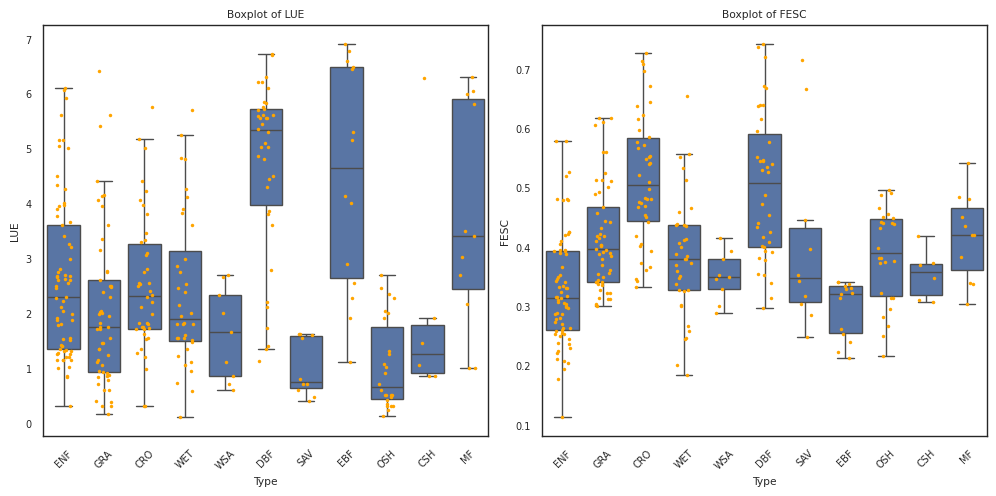

In [31]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the boxplot of "lue" on the first subplot
sns.boxplot(x="type", y="lai", data=site_annual_max_lue, showfliers=False, ax=ax1)
sns.stripplot(
    x="type",
    y="lai",
    data=site_annual_max_lue,
    color="orange",
    jitter=0.2,
    size=2.5,
    ax=ax1,
)
ax1.set_title("Boxplot of LUE")
ax1.set_xlabel("Type")
ax1.set_ylabel("LUE")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)  # Rotate x-labels by 45 degrees

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(x="type", y="fesc", data=site_annual_max_lue, showfliers=False, ax=ax2)
sns.stripplot(
    x="type",
    y="fesc",
    data=site_annual_max_lue,
    color="orange",
    jitter=0.2,
    size=2.5,
    ax=ax2,
)
ax2.set_title("Boxplot of FESC")
ax2.set_xlabel("Type")
ax2.set_ylabel("FESC")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate x-labels by 45 degrees

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

R: 0.2537137675412926
R^2: 0.06437067583999706


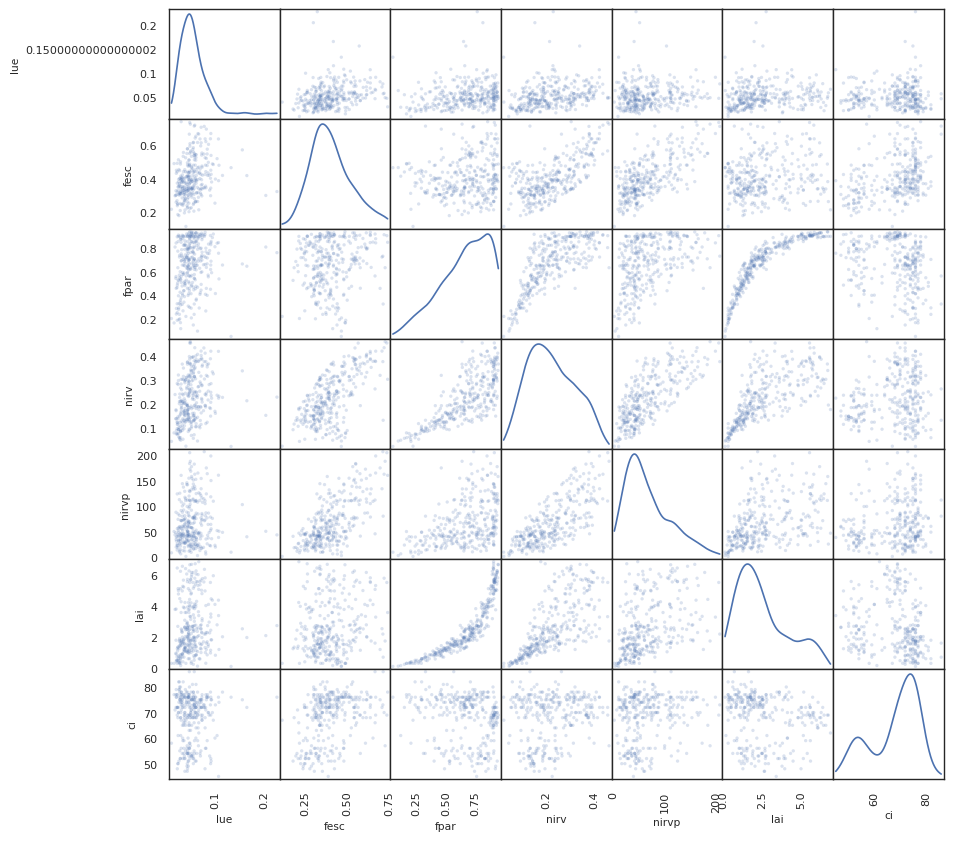

In [32]:
from sklearn.linear_model import LinearRegression

pd.plotting.scatter_matrix(
    site_annual_max_lue[["lue", "fesc", "fpar", "nirv", "nirvp", "lai", "ci"]],
    alpha=0.2,
    figsize=(10, 10),
    diagonal="kde",
)
# Create a linear regression model
model = LinearRegression()

# Fit the model using "fesc" as the independent variable and "lue" as the dependent variable
model.fit(site_annual_max_lue[["lue"]], site_annual_max_lue[["nirv"]])

# Calculate the R score
# r_score = model.score(site_annual_max_lue[["lue"]], site_annual_max_lue[["fesc"]])
# print("R score:", r_score)
r = np.corrcoef(site_annual_max_lue["lue"], site_annual_max_lue["nirv"])[0, 1]
print("R:", r)

r_squared = r**2
print("R^2:", r_squared)

In [33]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]

In [34]:
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "ci"]]
    .groupby("type")
    .median()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "ci"]]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)

In [35]:
# site_annual_max_lue_grouped_mean = site_annual_max_lue_grouped_mean.drop(
#     ["DBF_low", "SAV_low", "EBF_mid"], errors="ignore"
# )

In [36]:
site_annual_max_lue_grouped_mean

,fpar,nirv,nirvp,fesc,lue,lai,ci
type,,,,,,,
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,75.0
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,65.5
DBF,0.901250,0.362982,98.551784,0.506816,0.053090,5.3250,70.0
EBF,0.868125,0.201026,46.852877,0.320755,0.042413,4.6375,65.0
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,54.0
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,75.5
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,66.0
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,74.0
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,74.0


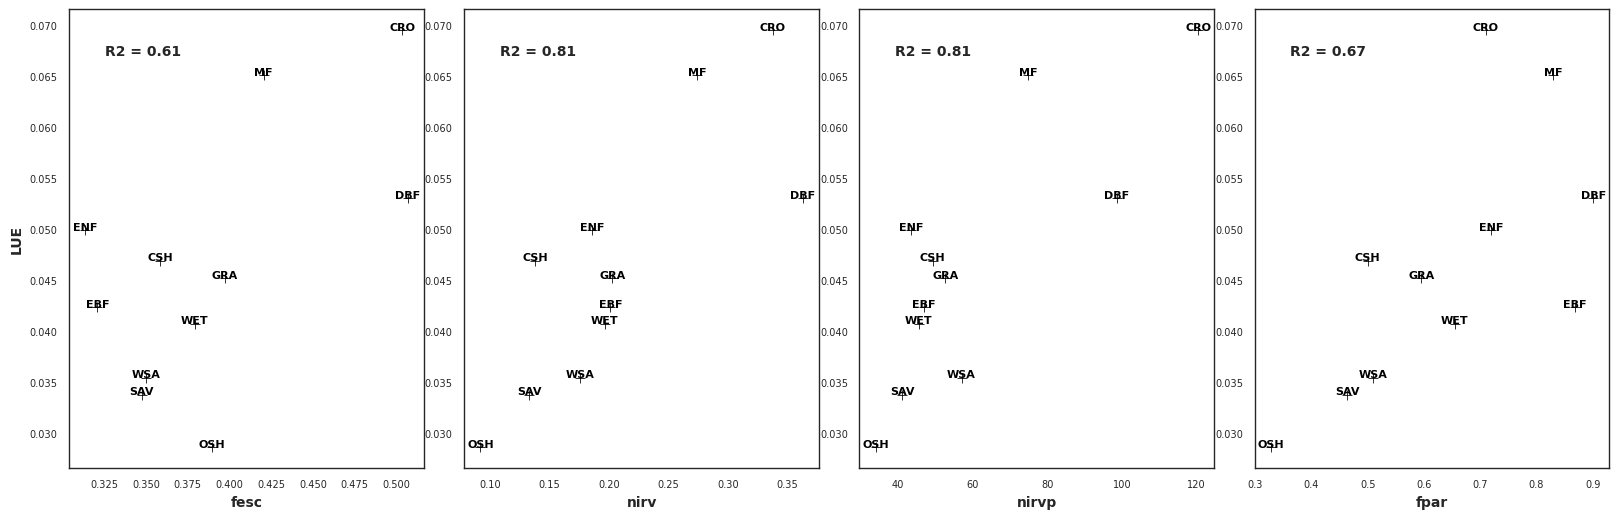

In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LUE", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
# print(results_df)

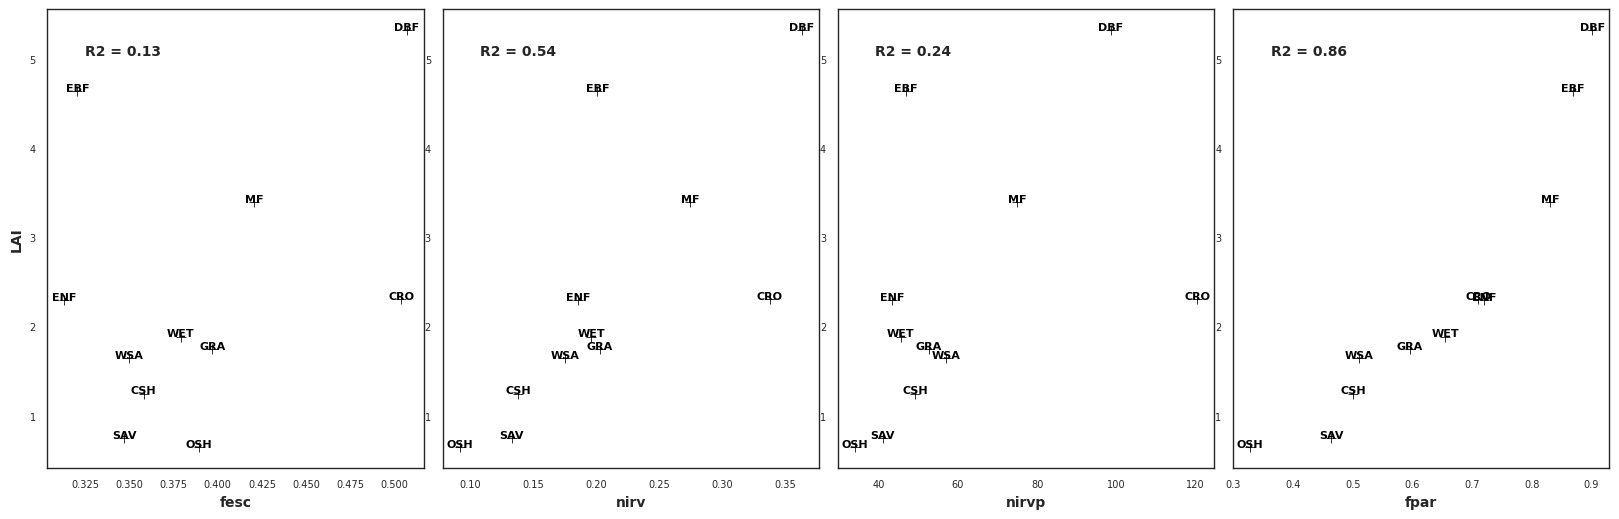

In [38]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lai"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LAI", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
# Display the DataFrame with results
# print(results_df)

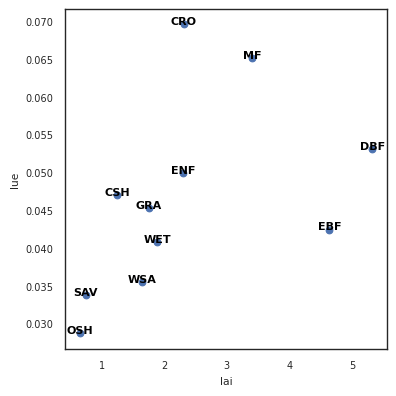

In [39]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
plt.figure(figsize=(4, 4))
# host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# Plot 'lai' vs 'lue'
plt.scatter(df_to_plot["lai"], df_to_plot["lue"])

# Add labels next to the points
for line in range(df_to_plot.shape[0]):
    plt.text(
        df_to_plot["lai"].iloc[line],
        df_to_plot["lue"].iloc[line],
        df_to_plot.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add labels to the axes
plt.xlabel("lai")
plt.ylabel("lue")

plt.tight_layout()
plt.show()

In [ ]:
site_annual_max_lue_grouped_mean["ci_lai"] = (
    site_annual_max_lue_grouped_mean["ci"] * site_annual_max_lue_grouped_mean["lai"]
)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "ci_lai"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("CI", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)


# Display the DataFrame with results
# print(results_df)

In [ ]:
import matplotlib.pyplot as plt

lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
lai_values = site_annual_max_lue_grouped_mean["lai"].values

# Calculate the derivatives
dlue_dlai = np.gradient(lue_values, lai_values)
dnirv_dlai = np.gradient(nirv_values, lai_values)

# Add the derivatives back to the DataFrame
site_annual_max_lue_grouped_mean["dlue_dlai"] = dlue_dlai
site_annual_max_lue_grouped_mean["dnirv_dlai"] = dnirv_dlai

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="lai", y="dlue_dlai", kind="scatter", ax=axs[0])

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[0].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Plot the 'dnirv_dlai' derivative
site_annual_max_lue_grouped_mean.plot(
    x="lai", y="dnirv_dlai", kind="scatter", ax=axs[1]
)
# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[1].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the R-squared value
# r2_linear = model.score(site_annual_max_lue_grouped_mean[['dlue_dlai']], site_annual_max_lue_grouped_mean[['dnirv_dlai']])

# Create a new figure
plt.figure(figsize=(6, 6))

# Plot the 'dnirv_dlai' derivative against the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="dlue_dlai", y="dnirv_dlai", kind="scatter")

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    plt.text(
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add the R-squared value to the plot
# plt.text(0.05, 0.95, f'R² = {r2_linear:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [ ]:
zi

In [ ]:
lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
ci_lai_values = site_annual_max_lue_grouped_mean["ci_lai"].values

# Calculate the derivatives
dlue_dci_lai = np.gradient(lue_values, ci_lai_values)
dnirv_dci_lai = np.gradient(nirv_values, ci_lai_values)

In [ ]:
plt.plot(ci_lai_values, dlue_dci_lai, "*")

In [ ]:
plt.plot(ci_lai_values, dnirv_dci_lai, "*")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "struct"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("structure", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)


# Display the DataFrame with results
# print(results_df)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="lue", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
plt.ylim(0, 0.18)
ax.grid(color="gray", linestyle="-", alpha=0.3)
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_lue_box.png")

In [ ]:
cite = pd.read_csv("../data/citations_for_site_data_Ameriflux.csv", skiprows=5)
cite.rename(columns={"site_id": "name"}, inplace=True)

# Initialize an empty DataFrame to store the results
data_cite = []

for name in names:
    site_name = name
    site_type = df[df["name"] == name]["type"].values[0]
    t1 = df[df["name"] == name].index[0]
    t2 = df[df["name"] == name].index[-1]
    date_range = str(t1.date()) + " - " + str(t2.date())
    site_cite = cite[cite["name"] == name]

    if len(site_cite) == 0:
        doi_url = "FLUXNET2015"
        data_cite.append(
            {
                "Name": site_name,
                "Type": site_type,
                "Date Range": date_range,
                "URL": doi_url,
            }
        )
        continue
    doi_url = site_cite["doi_url"].values[0]
    data_cite.append(
        {
            "Name": site_name,
            "Type": site_type,
            "Date Range": date_range,
            "URL": doi_url,
        }
    )
data_cite = pd.DataFrame(data_cite)
data_cite.to_csv("../outputs/data_cite.csv", index=False)

In [ ]:
results = []
for type in types:
    df_type = df[df["type"] == type]
    number_of_sites = len(df_type["name"].unique())
    number_of_obs = len(df_type)
    results.append(
        {
            "Type": type,
            "Number of Sites": number_of_sites,
            "Number of Observations": number_of_obs,
        }
    )
results = pd.DataFrame(results)
results.to_csv("../outputs/data_summary.csv", index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="fesc", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
ax.grid(color="gray", linestyle="-", alpha=0.3)
ax.xaxis.label.set_weight("bold")
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_fesc_box.png")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(
    style="white", context="paper", font_scale=0.8
)  # Changed style to "white" to remove grids

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(10, 2.5))  # Adjusted figure size
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Variable", "Slope", "Intercept", "R_squared"])

for i, x in enumerate(variables):
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Store slope, intercept, and R² in the DataFrame
    results_df.loc[i] = [x, model.coef_[0][0], model.intercept_[0], r2]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.01,
            df_to_plot[y].iloc[line] + 0.001,
            df_to_plot.index[line],
            horizontalalignment="center",
            size="small",
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )  # Reduced font size

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")  # Removing y-label
    if i == 0:
        host[i].set_ylabel(
            "LUE", fontsize=10, fontweight="bold"
        )  # Added y-label to the first subplot

plt.tight_layout(pad=0.01)  # Adjust subplot parameters to give specified padding
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
print(results_df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Load your data for site_annual_max_grouped_mean and site_annual_max_grouped_std
# Assuming these are already defined in your environment

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

for x in variables:
    # Create a single subplot with custom size
    fig, host = plt.subplots(1, 1, figsize=(3.5, 3.8))
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host,
        color="black",
        legend=False,
        s=50,
    )
    plt.errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_lue_grouped_se[x],
        yerr=site_annual_max_lue_grouped_se[y],
        fmt="none",
        color="black",
        alpha=0.25,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.002,
            df_to_plot[y].iloc[line] + 0.0005,
            df_to_plot.index[line],
            horizontalalignment="center",
            size=12,
            color="black",
            # weight="semibold",
        )

    # Add R² to the plot
    host.text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host.transAxes,
        fontsize=12,
        fontweight="bold",
    )

    # Set labels and title
    host.set_xlabel("")
    host.set_ylabel("")
    host.set_ylabel("")
    host.tick_params(axis="x", labelsize=12)
    host.tick_params(axis="y", labelsize=12)

    # Save the figure with x and y variables replaced in the filename
    plt.tight_layout(pad=0.01)
    plt.savefig(
        f"../outputs/figures/between_pft_{x}_{y}.png", dpi=300, bbox_inches="tight"
    )
    plt.clf()  # Clear the figure for the next iteration

# Close the figure
plt.close()

In [ ]:
site_annual_max_lue["type"].unique()

In [ ]:
types = site_annual_max_lue["type"].unique()

fig, axs = plt.subplots(3, 4, figsize=(10, 10))  # Reduced figure size to fit A4 paper
axs = axs.flatten()

for i, type in enumerate(types):
    print(type)
    x = "fesc"
    y = "lue"
    site_annual_max_type = site_annual_max_lue[site_annual_max_lue["type"] == type]
    site_annual_max_se_type = site_annual_max_lue_se[
        site_annual_max_lue_se["type"] == type
    ]
    df_to_plot = site_annual_max_type
    axs[i].scatter(
        df_to_plot[x], df_to_plot[y], color="black", marker="+", s=50
    )  # Added color, alpha, and edgecolor for better visualization
    axs[i].set_title(f"{type}", fontsize=12)  # Adjusted font size
    axs[i].set_xlabel(x, fontsize=12)  # Adjusted font size
    axs[i].set_ylabel("LUE$_{\mathrm{Max}}$", fontsize=12)

    axs[i].errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_se_type[x],
        yerr=site_annual_max_se_type[y],
        fmt="none",
        color="black",
        alpha=0.3,
    )

    # Calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    axs[i].text(
        0.1, 0.9, f"R² = {r:.2f}", transform=axs[i].transAxes, fontsize=12
    )  # Add R² to the plot
    axs[i].tick_params(axis="both", labelsize=8)  # Adjusted font size

# Remove the extra subplots
for j in range(len(types), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# plt.savefig(
#     "../outputs/figures/within_pft_fesc_lue.png", dpi=300, bbox_inches="tight"
# )  # Adjusted file name and dpi

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

variables = ["fesc"]  # Variables to loop over
y = "lue"
site_r2 = {var: [] for var in variables}  # Initialize a dictionary to store R² values
site_types = []  # Initialize a list to store the types

for name in names:
    tmp_df = df[df["name"] == name]
    site_types.append(tmp_df["type"].iloc[0])  # Append the type of the site
    for x in variables:
        model = LinearRegression().fit(tmp_df[[x]], tmp_df[[y]])
        r2 = model.score(tmp_df[[x]], tmp_df[[y]])
        site_r2[x].append(r2)  # Append R² to the corresponding list in the dictionary

# Convert the dictionary to a pandas DataFrame
r2_df = pd.DataFrame(site_r2, index=names)
r2_df["type"] = site_types  # Add the types as a new column

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

name = names[1]
tmp_df = df[df["name"] == name]
x = "lue"
y = "apar"
# Melt the DataFrame to have a long format
r2_df_melted = r2_df.melt(id_vars="type", var_name="variable", value_name="r2")

# Remove 'SNO' and 'CVM' types
r2_df_melted = r2_df_melted[~r2_df_melted["type"].isin(["SNO", "CVM"])]

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(
    x="type", y="r2", hue="variable", data=r2_df_melted, color="white"
)
# plt.title("R² for different variables by type")

# Change legend labels
new_labels = [f"{var} vs LUE" for var in r2_df.columns if var != "type"]
for t, l in zip(box_plot.legend_.texts, new_labels):
    t.set_text(l)
# Add horizontal line
plt.axhline(y=0.5, color="red", linestyle="--", c="gray")

# Remove legend title
box_plot.legend_.set_title(None)
box_plot.legend_.remove()
box_plot.set_xlabel("")
box_plot.set_ylabel(r"$R^2$", fontsize=14)
box_plot.tick_params(axis="x", labelsize=12)
box_plot.tick_params(axis="y", labelsize=12)
plt.savefig(
    "../outputs/figures/within_sites_r2_fesc_lue.png", dpi=300, bbox_inches="tight"
)